In [1]:
import numpy as np
import pandas as pd
# from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, make_scorer, roc_curve
import pickle

In [2]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

%matplotlib inline

# Display full content
# pd.set_option('display.max_colwidth', -1)
# np.set_printoptions(threshold=sys.maxsize)

# Avoid restarting Kernel
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Project libraries
%reload_ext autoreload
from NLP import WordBag

# Read objective and subjective training files

In [4]:
path = './data/'
subjective_file = 'subj_review.txt'

In [5]:
f = open(path + subjective_file, 'r', encoding='utf-8', errors='ignore')
subjective_lines = []
for line in f:
    subjective_lines.append(line)
f.close()

print('Subjective:',len(subjective_lines))
subjective_lines[0]

Subjective: 5060


'called " an elegant documentary " by sundance and " eloquent and deeply moving " by the la times , toyo miyatake : infinite shades of gray is a penetrating portrait of this photographer\'s search for truth and beauty in a world of impermanence . \n'

In [6]:
objective_file = 'obj_plot.txt'
f = open(path + objective_file, 'r', encoding='utf-8', errors='ignore')
objective_lines = []
for line in f:
    objective_lines.append(line.rstrip())
f.close()

print('Objective:',len(objective_lines))

Objective: 4941


In [7]:
objective_lines[0]

'while the now 72-year-old robert evans been slowed down by a stroke , he has at least one more story to tell : his own .'

In [8]:
word_bag = WordBag()
if False:  # CV score 0.88
    all_lines =  [word_bag.clean_text(sentence, remove_stop_words=False,remove_accents=True)
                  for sentence in (subjective_lines + objective_lines)]
else:
    all_lines =  [word_bag.remove_accents(sentence)
              for sentence in (subjective_lines + objective_lines)]
print(len(all_lines))
all_lines[:50]

10001


['called " an elegant documentary " by sundance and " eloquent and deeply moving " by the la times , toyo miyatake : infinite shades of gray is a penetrating portrait of this photographer\'s search for truth and beauty in a world of impermanence . \n',
 'their reporting becomes more compelling when they gather the courage to tell the truth about witnessing two of their peers throw a four-year-old out of a 14th story window . \n',
 "calvin's barbershop is filled with an eclectic and hilarious cast of characters that share their stories , jokes , trials and tribulations . \n",
 'simultaneously devastating and hilarious , the film manages to capture the daily rituals and mundanities of life in such engrossing proximity that everything becomes drama . \n',
 'in the hilarious comedy daddy day care , two fathers ( eddie murphy , jeff garlin ) lose their jobs in product development at a large food company and are forced to take their sons out of the exclusive chapman academy and become stay-a

## Create tf_idf = f(sentence,term)

In [9]:
tfidf = TfidfVectorizer() 
sentence_tfidf = tfidf.fit_transform(all_lines)
vocab = tfidf.vocabulary_
if False:
    tfidf_mat = sentence_tfidf
else:
    tfidf_mat = sentence_tfidf.todense()
print(type(tfidf_mat))
print(len(vocab))

<class 'numpy.matrix'>
20891


In [10]:
if True:
    pickle.dump(tfidf, open('fit_tfidf_vectorizer_for_obj_subj_sentences_classification.pkl', 'wb'))

In [11]:
#instead of default TFiDF, try:
# where 
if False:
    word_bag = WordBag()
    def dummy_fun(doc):
        return doc

    tfidf = TfidfVectorizer(
        analyzer='word',       # Feed a list of words to TF-IDF
        tokenizer=word_bag.comment_to_bag_of_words,
        preprocessor=dummy_fun,
        token_pattern=None,
        lowercase=False, 
        stop_words=None, 
        max_features=MAX_FEATURES,
        norm='l2',            # normalize each review
        use_idf=True)

In [12]:
sorted(vocab)[258:268]

['93',
 '94',
 '95',
 '996',
 '_boogie',
 'aaa',
 'aaliyah',
 'abandon',
 'abandone',
 'abandoned']

In [13]:
tfidf_mat[:2,270:300]

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.12003052,
         0.        , 0.        , 0.        , 0.        , 0.        ]])

## Create Train and CV sets

In [14]:
labels = np.concatenate((np.zeros((len(subjective_lines),), dtype=int), np.ones((len(objective_lines),), dtype=int)))
print(labels.shape)
labels[4990:5010]

(10001,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_cv, y_train, y_cv = train_test_split(
    tfidf_mat, labels, test_size=0.2, random_state=0)

In [16]:
print(X_train.shape, X_cv.shape, y_train.shape, y_cv.shape)

(8000, 20891) (2001, 20891) (8000,) (2001,)


## Gradient Boosting

In [17]:
# N_TREES = 300
# LEARN_RATE = 0.2
# MIN_IN_LEAF = 10
# CV score: 0.8285

# 107 trees
# LEARN_RATE = 0.2
# MAX_DEPTH = 8
# MIN_IN_LEAF = 5 #7
# MAX_FEATURES = 'sqrt'
# CV score: 0.8415

# Gradient Boosting Classifier parameters
# N_TREES = int(round(np.sqrt(X_train.shape[0]) * 1.2))
# CV score should be 0.8815
N_TREES = 300
LEARN_RATE = 0.5
MAX_DEPTH = 16
MIN_IN_LEAF = 5 #7
MAX_FEATURES = 'sqrt'
N_TREES

300

In [18]:
print(y_train[0])
print(X_train[0])


0
[[0. 0. 0. ... 0. 0. 0.]]


In [19]:
from sklearn.ensemble import GradientBoostingClassifier

# loss: deviance: logistic log likelihood
gbc = GradientBoostingClassifier(learning_rate=LEARN_RATE, 
                                   n_estimators=N_TREES, 
                                   min_samples_leaf=MIN_IN_LEAF,
                                   max_features=MAX_FEATURES)
gbc.fit(X_train, y_train)
print('Train score:', gbc.score(X_train, y_train))
print('CV score:', gbc.score(X_cv, y_cv))

Train score: 0.96125
CV score: 0.8915542228885557


In [20]:
# save the model
import pickle
pickle.dump(gbc, open('GBC_'+ str(N_TREES) +'_' + str(LEARN_RATE) 
                        +'_' + str(MIN_IN_LEAF) + '_0.88cv.pkl', 'wb'))


# Inspect proba

In [21]:
label_pred = gbc.predict_proba(tfidf_mat)

In [22]:
print(label_pred[:10,1])
print(labels[:10])

[0.10212008 0.4388384  0.03391372 0.01147602 0.79546388 0.2059679
 0.4995056  0.0346163  0.3126044  0.0477799 ]
[0 0 0 0 0 0 0 0 0 0]


In [23]:
print(label_pred[-10:,1])
print(labels[-10:])

[0.9925437  0.96968996 0.78705443 0.93438355 0.64749501 0.92533485
 0.7191669  0.97464956 0.82065296 0.85021804]
[1 1 1 1 1 1 1 1 1 1]


Text(0.5, 1.0, 'ROC plot')

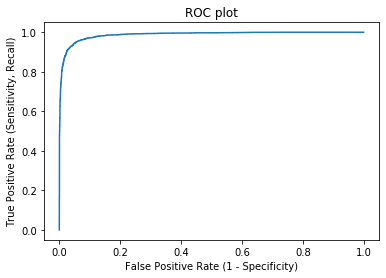

In [24]:
fpr, tpr, thresholds = roc_curve(labels, label_pred[:,1])
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot")

## False Positives at 80% confidence: predicted objective, actual subjective

In [27]:
THRESHOLD = 0.8
all_lines_arr = np.array(all_lines)

In [38]:
TP = all_lines_arr[(label_pred[:,1] > THRESHOLD) & (labels == 1)]
FP = all_lines_arr[(label_pred[:,1] > THRESHOLD) & (labels == 0)]
TP_nb = len(TP)
FP_nb = len(FP)
predicted_P = FP_nb + TP_nb

display(Markdown('### {} sentences falsely predicted objective with {}% confidence:'.format(FP_nb, THRESHOLD * 100)))
for i, sent in enumerate(FP):
    print(i, sent)

### 25 sentences falsely predicted objective with 80.0% confidence:

0 no doubt the star and everyone else involved had their hearts in the right place . where their heads were is anyone's guess . 

1 an average coming-of-age tale elevated by the wholesome twist of a pesky mother interfering during her son's discovery of his homosexuality . 

2 by the time the surprise ending is revealed , interest cannot be revived . 

3 once she lets her love depraved leads meet , [denis'] story becomes a hopeless , unsatisfying muddle

4 for the future , one hopes mr . plympton will find room for one more member of his little band , a professional screenwriter . 

5 in scope , ambition and accomplishment , children of the century . . . takes kurys' career to a whole new level . 

6 the only camouflage carvey should now be considering is a paper bag to wear over his head when he goes out into public , to avoid being recognized as the man who bilked unsuspecting moviegoers . 

7 a tender and touching drama , based on the true story of a troubled african-american's ques

## Some false negatives at 80% confidence: Predicted subjective, actually objective

In [42]:
TN = all_lines_arr[(label_pred[:,0] > THRESHOLD) & (labels == 0)]
FN = all_lines_arr[(label_pred[:,0] > THRESHOLD) & (labels == 1)]
TN_nb = len(TN)
FN_nb = len(FN)

display(Markdown('### {} sentences falsely predicted objective with {}% confidence:'.format(FN_nb, THRESHOLD * 100)))
print('Several sentences are incorrectly labeled and would need to be re-classified')
for i, sent in enumerate(FN):
    print(i, sent)

### 39 sentences falsely predicted objective with 80.0% confidence:

0 decent-but-dull dek loves shirley , so much so that he humiliates her by proposing without warning on national television .
1 as in his previous films , this kurdish director is again focusing on the oppression of his people .
2 this startling film provides a gritty look into american politics in the new south .
3 the movie features veteran horror heroines leslie culton and jenny wallace , and actors john saenz and jonathan tabor .
4 they are under the impression that models have more beauty than brains and are not capable of much more than looking good .
5 in this cinematic concert , mesmerizing images are plucked from everyday reality , then visually altered with state-of-the-art digital techniques .
6 set in hollywood , " coming clean " is a 12 character ensemble romantic comedy about an engagement party gone wrong .
7 serious and conservative , jamie ( moore ) was as far from cool as she could possibly be , and didn't care .
8 the fact that the filmmakers family is integral to th

# Grid search

In [ ]:
if True:
    grid = {
        'learning_rate': [.01, .05],
        'max_depth': [8, 16],
        'min_samples_leaf': [5],
        'max_features': ['sqrt'],
        'n_estimators': [300],
        'random_state': [0],
    }
else:  # TEST
    grid = {
    'learning_rate': [1],
    'max_depth': [2], 
    'min_samples_leaf': [2],
#     'max_features': ['sqrt', None],
    'n_estimators': [2],
    'random_state': [0]
}
    
# confusion_score = make_scorer(confusion_rmse, greater_is_better=False)

scorer = make_scorer(recall_score)
gbc_grid_cv = GridSearchCV(
    GradientBoostingClassifier(), 
    grid,
    cv=4,  # number of folds
    return_train_score=True,
    scoring=scorer,
    verbose=1, 
    n_jobs=-1)
gbc_grid_cv.fit(X_train, y_train)

In [ ]:
y_pred = gbc_grid_cv.predict(X_cv)

print(gbc_grid_cv.best_params_)
print(gbc_grid_cv.best_score_)
res_df = pd.DataFrame(gbc_grid_cv.cv_results_)
print('Used recall for scoring')
res_df